# Matt's Mini Project 1 - Predicting heart attacks - A study

# Introduction

As our society leans towards more comfort and faster foods, there tends to be more detrimental side effects to our health due to lack of exercise and more fatty diets. According to the American Heart Association News (2018), there has been an increase of 50% in heart attacks of younger peoples (35-54 Y.O.) in a study on data collected between 1995-2014.

This mini project aims at examining heart test data to see if there are any clear trends between risk of heart attacks and lifestyle markers such as blood cholesterol levels, rest heart rates, etc... and whether it is possible to predict the likelihood of developing a heart attack in the future given data that is not from the dataset.

In Part 1, I will be performing Exploratory Data Analysis (EDA) on the given data, and use that data in Part 2 to perform deeper analysis and predictions on the likelihood of developing serious heart conditions.

<img src="Illustration-of-the-Human-heart.jpg" alt="Drawing" style="width: 400px;"/>

Credit: https://interactive-biology.com/wp-content/uploads/2012/05/Illustration-of-the-Human-heart.jpg

### Questions to be answered:

1 - Which factor(s) has/have the most influence (correlation) with the chance of suffering a heart attack?<br>
2 - Is it possible to predict the likelihood of a heart attack using the given data?

# Part 1: Performing EDA on heart attack data.

The data set is acquired from kaggle (using the kaggle API), which has been imported from: https://archive.ics.uci.edu/ml/datasets/Heart+Disease. <br>
I will be performing EDA first to see if there are any trends and if I need to clean up any data.


In [49]:
import numpy as np
import pandas as pd
from scipy import stats
import requests
import json
from datetime import datetime, date, time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [50]:
#Connecting with the API and authenticating
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

I use the Kaggle API to download the heart dataset

In [51]:
api.dataset_download_file('rashikrahmanpritom/heart-attack-analysis-prediction-dataset','heart.csv')

False

In [52]:
heart = pd.read_csv('heart.csv')

In [53]:
heart.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Preliminary EDA

In [54]:
heart.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Insights:

- Most of the data in this dataset are categorical, with values vetween 0 and 1, and sometimes up to 4.
- There is a large number for 'zero' height peaks from an ECG test in the oldpeak column

In [55]:
selection = heart[heart['oldpeak']==0]
selection.shape

(99, 14)

There are 99 rows of zero data for peaks. I could remove those rows but that would also remove valuable data that will help with the analysis, so I will leave those rows in for the sake of better overall analysis.

**For below:** I referred to the UCI website to get the descriptions of the column headings for context.

Column headings:
    
- **age**: Age of person at time of test
- **sex**: Sex of person at birth
- **cp**: Chest pain type: 1 = typical angina (a specific type of chest pain), 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic
- **trtbps**: Resting blood pressure (in mm Hg)
- **chol**: Cholesterol level in mg/dl fetched via BMI sensor
- **fbs**: Fasting blood sugar > 120 mg/dl. 1 = True, 0 = False.
- **restecg**: ECG reading at rest. 0 = normal. 1 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
- **thalachh**: maximum heartrate achieved
- **exng**: Exercise-induced angina (1 = Yes, 0 = No)
- **oldpeak**: A specific peak from the ST depression on the ECG output
- **slp**: the slope of the peak exercise ST segment
- **caa**: number of major vessels (0-3) colored by flourosopy
- **thal**: Defect: 3 = normal; 6 = fixed defect; 7 = reversible defect
- **output**: Has had a heart attack or not (1 = Yes, 0 = No)

| Column heading | Description |
|:--------------|:-----------|
| **age** | Age of person at time of test      |
| **sex**      | Sex of person at birth |
| **cp**      | Chest pain type: 1 = typical angina (a specific type of chest pain), 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic  |
| **trtbps**      | Resting blood pressure (in mm Hg)  |
| **chol**      | Cholesterol level in mg/dl fetched via BMI sensor  |
| **fbs**      | Fasting blood sugar > 120 mg/dl. 1 = True, 0 = False.  |
| **restecg**      | ECG reading at rest. 0 = normal. 1 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)  |
| **thalachh**      |  Maximum heartrate achieved  |
| **exng**      | Exercise-induced angina (1 = Yes, 0 = No)  |
| **oldpeak**      | A specific peak from the ST depression on the ECG output |
| **slp**      | the slope of the peak exercise ST segment |
| **caa**      | number of major vessels coloured by fluoroscopy |
| **thal**      | Defect: 3 = normal; 6 = fixed defect; 7 = reversible defect |
| **output**      | Has Had a heart attack (1 = Yes, 0 = No)  |

#### Checking dataset shape

In [56]:
print ('The shape of the dataset is', heart.shape)

The shape of the dataset is (303, 14)


#### Checking for null values

In [57]:
heart.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

Comment: No null values. Good start.

#### Checking column types

In [58]:
heart.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

#### Correlation Data

In [59]:
corr = heart.corr()
corr

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trtbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalachh,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exng,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


## Plots

### Correlation heatmap

<AxesSubplot:>

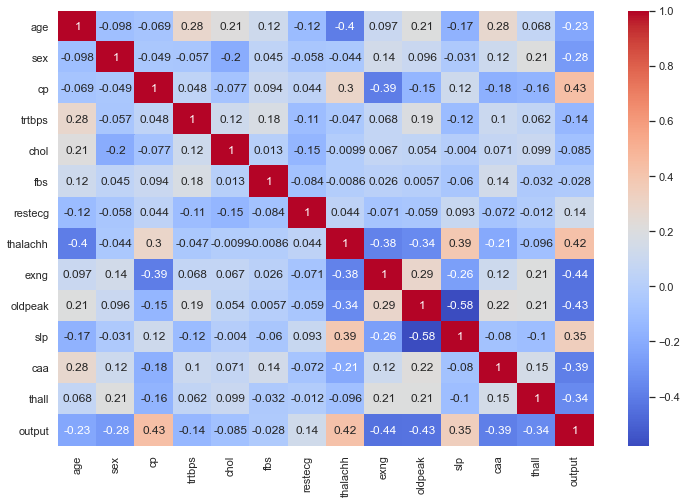

In [91]:
plt.figure (figsize = (12,8))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap = 'coolwarm', annot = True)

Notes: Strong correlation between most of the variables except for chol, tbs and restecg and trbps.

#### Total outputs of heart attacks:

In [61]:
heart['output'].value_counts()

1    165
0    138
Name: output, dtype: int64

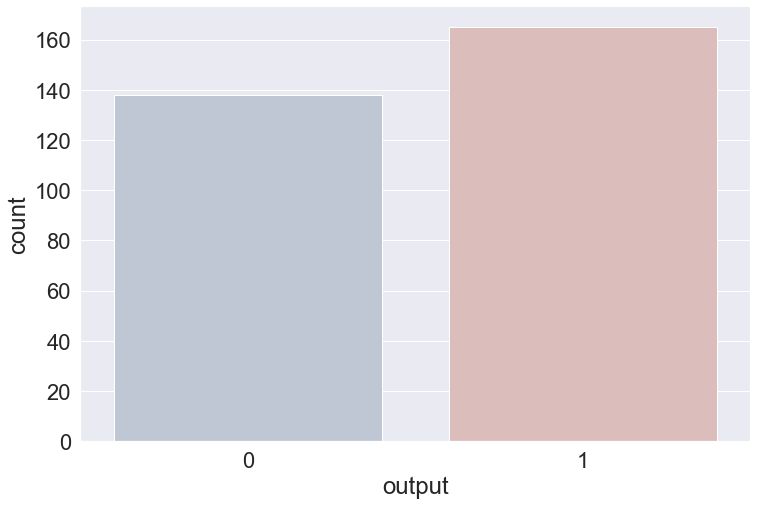

In [62]:
fig = plt.figure(figsize = (12,8));
sns.set_style("darkgrid")
sns.set(font_scale=2)
sns.countplot(data=heart, x = 'output', palette='vlag');
plt.show();

In this study, 165 people out of 303 people 54% of the people had suffered a heart attack or at very high risk of suffering one.

#### Male and female distribution

In [63]:
heart['sex'].value_counts()

1    207
0     96
Name: sex, dtype: int64

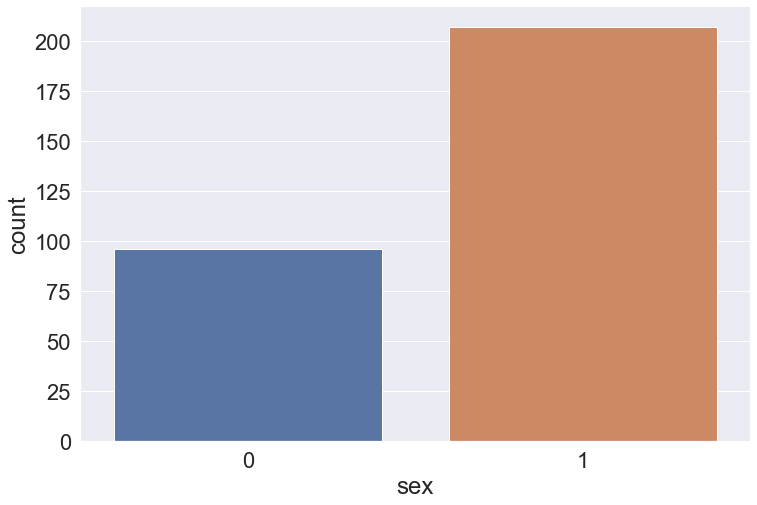

In [64]:
fig = plt.figure(figsize = (12,8));
sns.set_style("darkgrid")
sns.set(font_scale=2)
p = sns.countplot(data=heart, x="sex")
plt.show()

Without knowing how this data has been collected, we cannot assume that 0 or 1 are male or female.

However,  According to the Harvard Medical School:

>__Researchers found that throughout life, men were about twice as likely as women to have a heart attack. That higher risk persisted even after they accounted for traditional risk factors for heart disease, including high cholesterol, high blood pressure, diabetes, body mass index, and physical activity.__

This, we can assume that 1 is male and 0 is female, purely based off real world statistics.

#### Age distribution

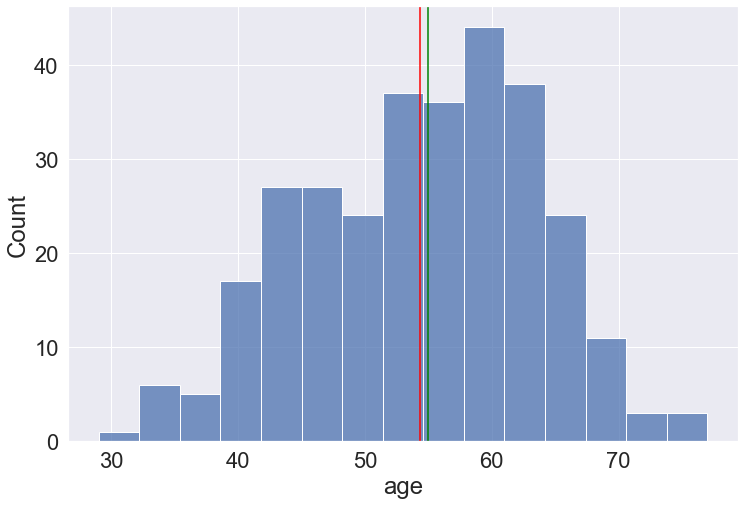

In [93]:
fig = plt.figure(figsize = (12,8));
sns.set(font_scale=2)
sns.set_style("darkgrid")
plt.axvline(x=heart['age'].mean(), color='red')
plt.axvline(x=heart['age'].median(), color='green')
p = sns.histplot(data=heart, x="age", bins = 15)

**Note**: The mean line is in red and the median is in green.<br>
**Insights**: The majority of the people tested were of more advanced age, the majoriy of the people around the 60 year old age.

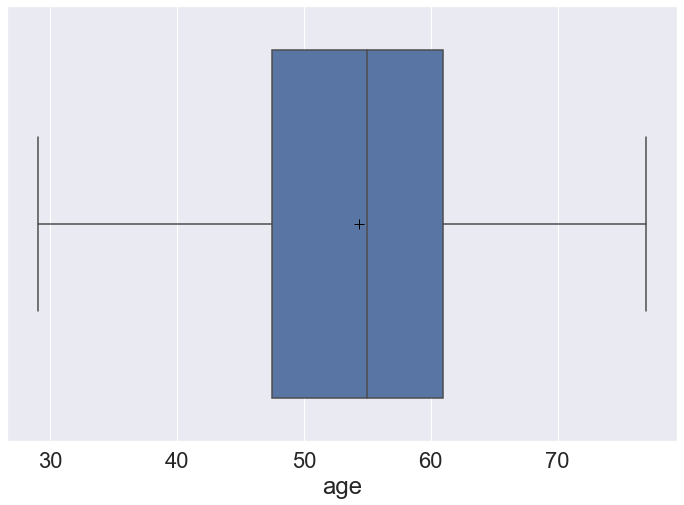

In [66]:
fig = plt.figure(figsize = (12,8));
sns.set_style("whitegrid")
sns.set(font_scale=2)
p = sns.boxplot(data=heart, x="age", showmeans=True, 
                meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"}, palette = 'deep')

Credit to geeks for geeks for the mean marker code. https://www.geeksforgeeks.org/how-to-show-mean-on-boxplot-using-seaborn-in-python/

#### Exercise-induced angina breakdown

In [67]:
ang = heart.fbs.value_counts()
print(ang)

0    258
1     45
Name: fbs, dtype: int64


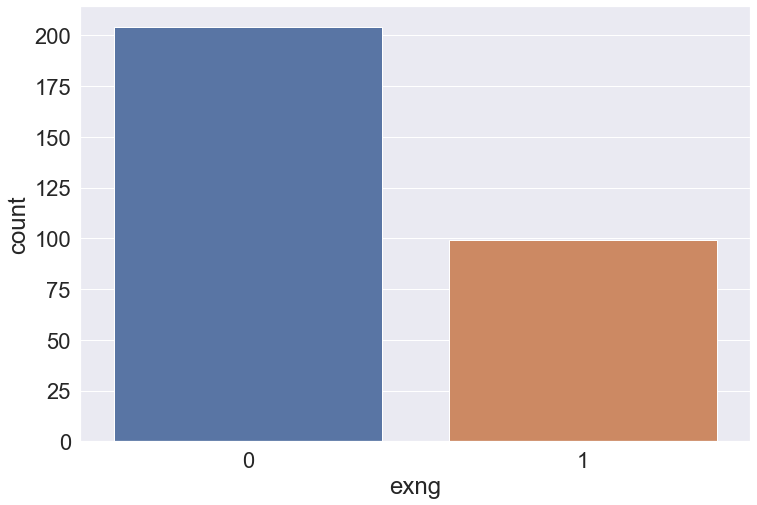

In [68]:
fig = plt.figure(figsize = (12,8));
sns.countplot(data=heart, x="exng")
sns.set(font_scale=2)
plt.show()

Comment: 1/6th (45 out of 303) of the population experienced exercise-induced angina

#### Visualising the relationship between age and heart attacks:

<Figure size 864x576 with 0 Axes>

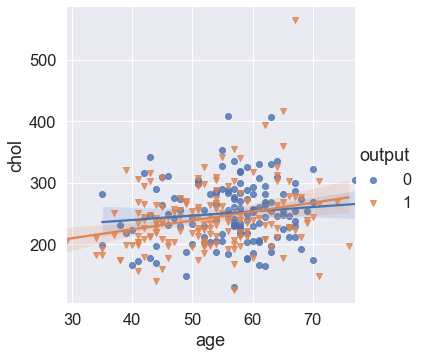

In [69]:
fig = plt.figure(figsize = (12,8));
sns.set(font_scale=1.5)
sns.lmplot(x = 'age', y = 'chol', data = heart, hue = 'output', markers =['o', 'v'])

Comments: 

- Roughly speaking, higher cholesterol measurement with greater age.

- We can conclude that cholesterol levels alone are not indicative of potential heart attacks

Interestingly, younger members of the population suffered heart attacks

#### Heart attacks vs age as a pdf

Note: Credit to **Fahad Mahfoooz** on Kaggle for guidance to the plot below:

C:\Users\matta\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\matta\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


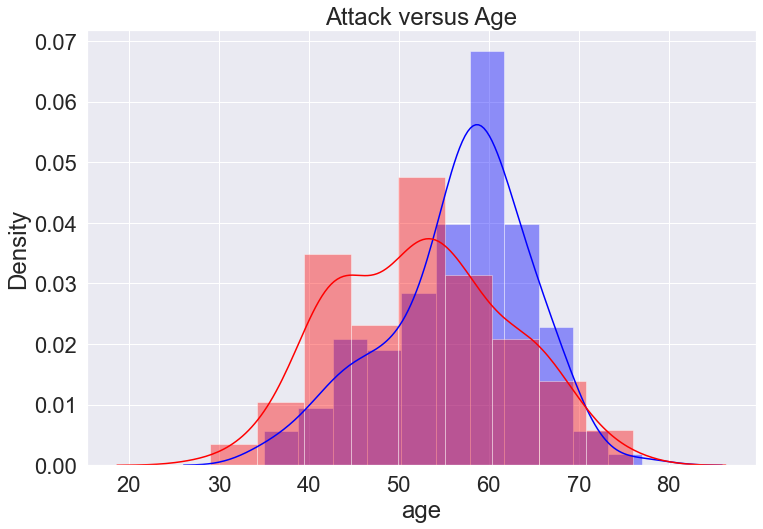

In [95]:
fig = plt.figure(figsize = (12,8));
sns.distplot(heart[heart['output'] == 0]["age"], color='blue',kde=True,);
sns.distplot(heart[heart['output'] == 1]["age"], color='red',kde=True);
plt.title('Attack versus Age');
plt.show();

Insights:
- The peak for people who did not have a heart attack but showed with symptoms was around 62 years of age.
- The peak for people who did have a heart attack was around 52 years of age.

Thus, we can conclude that age alone is not a determining factor in predicting heart attacks.

#### Heart attacks as a function of cholesterol

C:\Users\matta\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\matta\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


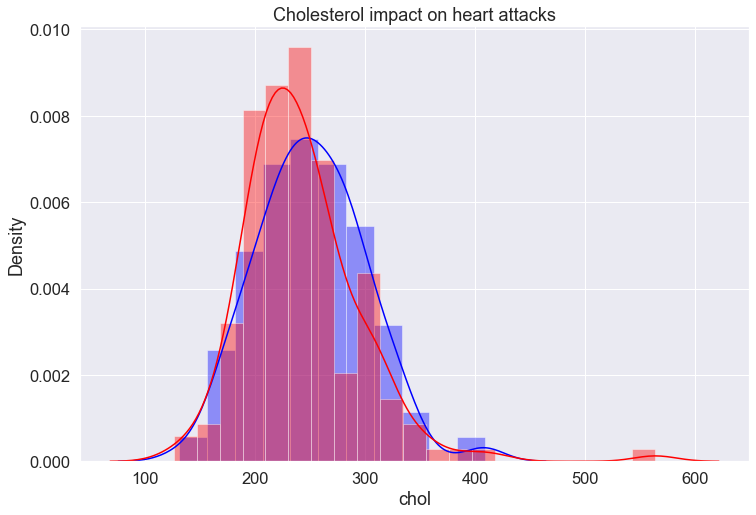

In [71]:
fig = plt.figure(figsize = (12,8));
sns.distplot(heart[heart['output'] == 0]["chol"], color='blue',kde=True,);
sns.distplot(heart[heart['output'] == 1]["chol"], color='red',kde=True);
plt.title('Cholesterol impact on heart attacks');
plt.show();

Below I will test the p-value of these 2 data segments

In [72]:
stats.ttest_ind(heart[heart['output'] == 0]["chol"],heart[heart['output'] == 1]["chol"])[1]

0.13879032695600638

Insights:

- The population cholesterol was roughly the same for people who had and people who did not have heart attacks. Thus, cholesterol alone cannot be a true test for probability of heart attacks.

- This is confirmed by the high p-value (>0.05), this we do not reject the null hypothesis (the two samples are similar, thus no statistically significant difference)

#### Heart attacks as a function of max heart rate

C:\Users\matta\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\matta\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


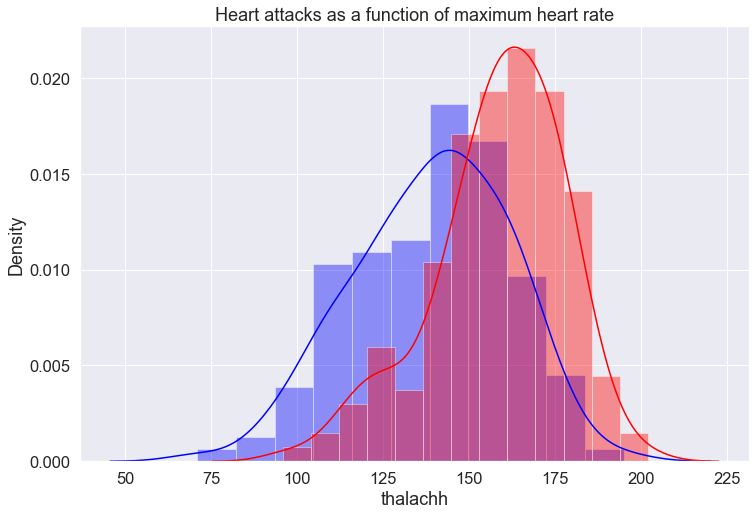

In [73]:
fig = plt.figure(figsize = (12,8));
sns.distplot(heart[heart['output'] == 0]["thalachh"], color='blue',kde=True,);
sns.distplot(heart[heart['output'] == 1]["thalachh"], color='red',kde=True);
plt.title('Heart attacks as a function of maximum heart rate');
plt.show();

Statistics test:

In [74]:
stats.ttest_ind(heart[heart['output'] == 0]["thalachh"],heart[heart['output'] == 1]["thalachh"])[1]

1.697337638656049e-14

Insights:

- In here, it is much clearer that the blue (had a heart attack) has a good correlation with a higher heart rate. This could be due to the fact that a higher heart rate could cause excess strain on the heart, which leads to a heart attack. Or, alternatively, a previous heart attack has weakened the heart which leads to a higher heart rate after excercise.

- the small p-value (<0.05) rejects the null hypothesis that these 2 samples are identical, which means there is a significant difference between the two samples, which means that there is possible correlation between a higher heart rate and chance of heart attacks.

#### A different view:

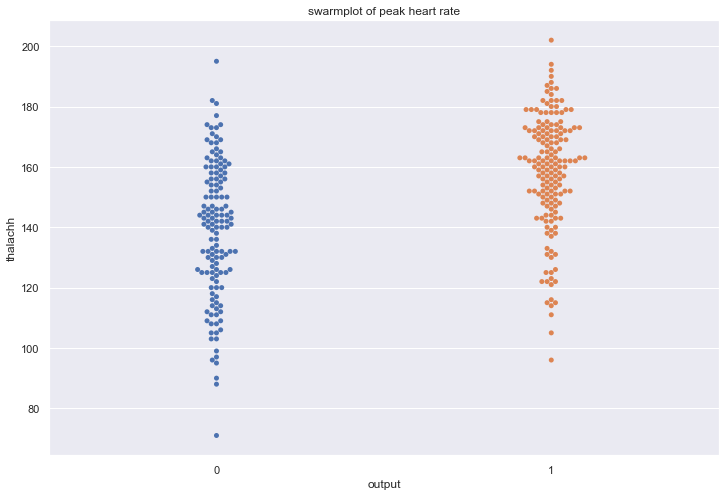

In [97]:
sns.set(rc={"figure.figsize":(12, 8)});
sns.swarmplot(x='output',y='thalachh', data=heart);
plt.title ('swarmplot of peak heart rate');

This seems to agree with the above analysis of a higher heart rate being positively correlated with higher probability of heart attacks.

#### Heart rate vs cholesterol with output hue.

<Figure size 864x576 with 0 Axes>

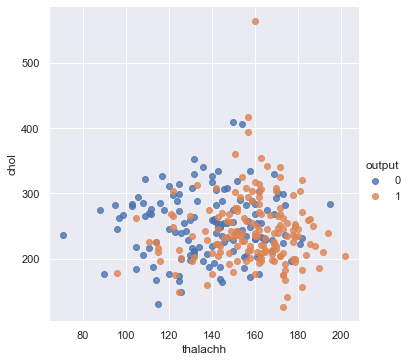

In [76]:
fig = plt.figure(figsize = (12,8));
sns.lmplot(x='thalachh',y='chol', hue = 'output', data=heart,fit_reg=False);

Visually speaking, the higher the heart rate, the higher the likelihood of a heart attack.

### Conclusions of part 1:

Purely from EDA, one can make the following observations:
 - the higher the peak heart rate is, the more likely a heart attack is to develop.
 - Younger people seemed to suffer more heart attacks than older people (in the study).
 - People who recorded chest pains were more likely to develop a heart attack. (Evident from the correlation matrix)

# Part 2: Creating a predictive model to predict heart attacks

### Linear Regression

In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Setting the target variablea s heart attacks (output):

In [78]:
#The target variable - output
y = heart['output']

#### Creating the prediction variable matrix:

These variables were chosen based on them being continuous numerical variables and having strong correlation with the heart attack target variable.

In [79]:
#The prediction matrix:
pred_mat = heart[['thalachh', 'exng', 'oldpeak']]

In [80]:
pred_mat.head(4)

,thalachh,exng,oldpeak
0,150,0,2.3
1,187,0,3.5
2,172,0,1.4
3,178,0,0.8


In [81]:
# Train-Test Split
X = pred_mat
#y being the Outcome is defined earlier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### Linear regression model

In [82]:
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)

# Calculate the score (R^2 for Regression) for Training Data
score_train = linear_regression.score(X_train, y_train)

# Calculate the score (R^2 for Regression) for Testing Data
score_test = linear_regression.score(X_test, y_test)
print (score_train, score_test)

0.3271968050625963 0.3392607971142154


Close scores, the model is a good model.

In [83]:
#Checking the coeff and int:
reg_coeff = linear_regression.coef_ #This outputs the coefficients for the matrix and stores it into reg_coeff
reg_int = linear_regression.intercept_ #This stores the intercept into reg_int

reg_coeff, reg_int

(array([ 0.00401903, -0.29782752, -0.13461982]), 0.1762003693219421)

### Testing the model

Assume the values for the thalachh, exng, oldpeak to be: 190, 0.5, 5 respectively. We will use the model to predict whether this person would be likely to suffer a heart attack in the future

In [98]:
pred_qual = linear_regression.predict(np.array([[190, 0.5, 1]]))[0]
round(pred_qual*100, 2)

65.63

According to the linear regression model, this person has a 65.6% chance of suffering a heart attack in the future based on the three predicter variables chosen.

### Logistical Regression model

In [85]:
from sklearn.linear_model import LogisticRegression

I will include the categorical variables, along with the numerical variables, in the prediction matrix for Logistical Regression, to see if I can improve the score.

In [86]:
y = heart['output'] #Target variable
X = heart[['thalachh', 'exng', 'oldpeak', 'slp','caa']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [87]:
# Build Model
model = LogisticRegression()

# Fit Model
model.fit(X_train,y_train)

# Score

score_train = model.score(X_train, y_train)

# Calculate the score (R^2 for Regression) for Testing Data

score_test = model.score(X_test, y_test)

print (score_train, score_test)

0.7851239669421488 0.8524590163934426


Significantly higher score (Accuracy) values, and close scores for the test and train inputs, which means that is a good model for predicting heart attacks. I will use the values from before to see if the model can properly predict the possibility of a heart attack in the same person from the Linear Regression analysis:

In [88]:
pred_qual = model.predict(np.array([[190, 0.5, 1, 1, 1]]))[0]
pred_qual

1

The logistical regression model guarantees that this person will suffer a heart attack due to their conditions.

#### Check the validity of the model

I wanted to check the validity of the model, so I decided to produce a ROC plot.

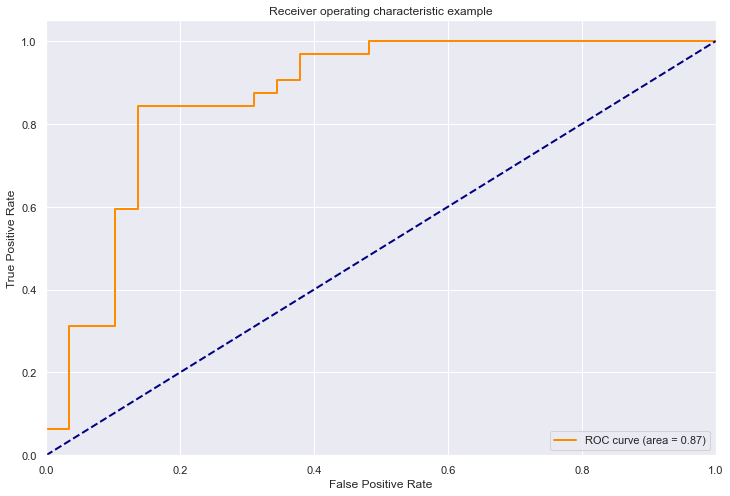

In [89]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = model.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

The area under an ROC curve is a measure of the usefulness of a test in general, where a greater area means a more useful test, the areas under ROC curves are used to compare the usefulness of tests. Since this area is fairly large (0.87), then this is a useful test, thus a respectible prediction. 

#### Accuracy test

In [90]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_train)
round(accuracy_score(y_train, y_pred)*100, 1)

78.5

This model has a 78.5% accuracy for predicting heart attacks

### Answers to the original questions:
1 - The numerical factor with the highest correlation with heart attacks is maximum heartrate achieved during exercise. The higher it is, the more likely the chance of a heart attack (0.43 correlation). <br>

2 - It is possible to predict the likelihood of a heart attack, ideally using Logistical Regression.

# Conclusion

From this study, we can conclude that higher risks of heart attack can be correlated with higher heart rates (resting and exercising) and whether previous chest pain (specifically, angina) has been experienced. An interesting note to make is that the severity of the ECG graphs also positively correlated with higher risk of heart attacks. All of those factors essentially amount to the following: _An over worked and stressed out heart will lead to having a heart attack_.

Therefore, it is very important to exercise effectively and eat well to reduce the stresses on the heart, thus preventing heart attacks in the long run.